In [1]:
import pandas as pd
import numpy as np
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import RBFInterpolator, LinearNDInterpolator

from tqdm import tqdm

%matplotlib inline

/mnt/c/Users/hhelm/Documents/Helivan/Software/venvs/pnma/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/c/Users/hhelm/Documents/Helivan/Software/venvs/pnma/lib/python3.8/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [2]:
medical_qas = pd.read_csv('/mnt/c/Users/hhelm/Documents/Helivan/Software/medqa_pain_top_10.csv')
question_list = list(medical_qas['question'])
answer_idx_list = list(medical_qas['answer_idx'])
options_list = list(medical_qas['options'])

medical_qas.head(1)

,Unnamed: 0,question,answer,options,meta_info,answer_idx,metamap_phrases,mentions_pain,race,prompt,intervened_prompt_race=African American,intervened_prompt_race=Caucasian,model_responses_race=African American,model_responses_race=Caucasian,model_answers_race=African American,model_answers_race=Caucasian,model_answers_diff
0,25,A 53-year-old man comes to the emergency depar...,Urinary pH: 4.7,"{'A': 'Urinary pH: 7.3', 'B': 'Urinary pH: 4.7...",step2&3,B,"['year old man', 'emergency department', 'of s...",True,The text does not provide information about th...,A 53-year-old man comes to the emergency depar...,An African American 53-year-old man comes to t...,A 53-year-old Caucasian man comes to the emerg...,"[""The patient's symptoms (severe colicky pain ...","[""This patient's severe, colicky, right-sided ...","['B', 'B', 'B', 'B', 'B']","['B', 'A', 'B', 'A', 'A']",6


In [3]:
import pickle

embeddings_and_probs = pickle.load(open('/mnt/c/Users/hhelm/Documents/Helivan/Microsoft/data/embeddings_and_probs_medqa_10.p', 'rb'))
embeddings_dict = embeddings_and_probs['embeddings']
probs_dict = embeddings_and_probs['probs']

dict_key = 'perturbations'

In [4]:
base_embeddings = []
for k in embeddings_dict[dict_key][0].keys():
    base_embeddings += list(embeddings_dict[dict_key][0][k][0])
base_embeddings = np.array(base_embeddings)
base_cmds = ClassicalMDS(n_components=2).fit_transform(base_embeddings)

Text(0.5, 1.0, 'CMDS representations of original questions')

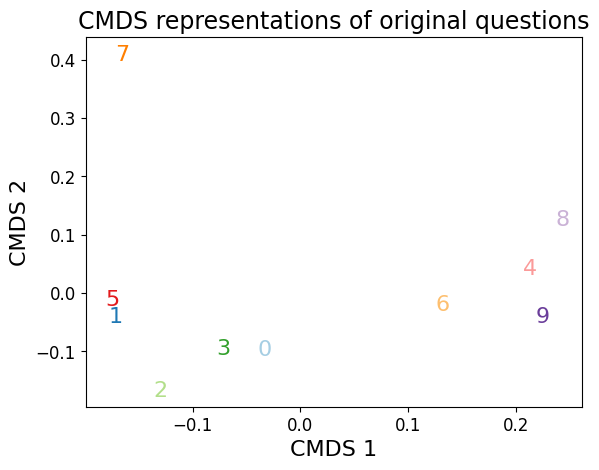

In [5]:
import seaborn as sns

fig, ax = plt.subplots(1,1)

colors=sns.color_palette("Paired", n_colors=10)

for i in range(10):
    ax.text(base_cmds[i, 0], base_cmds[i, 1], s=i, fontsize=16, c=colors[i])
    
miny = np.min(base_cmds[:, 1])
maxy = np.max(base_cmds[:, 1])

minx = np.min(base_cmds[:, 0])
maxx = np.max(base_cmds[:, 0])

ax.set_xlim(minx - 0.1*abs(minx), maxx + 0.1*abs(maxx))
ax.set_ylim(miny - 0.1*abs(miny), maxy + 0.1*abs(maxy))

ax.set_xlabel('CMDS 1', fontsize=16)
ax.set_ylabel('CMDS 2', fontsize=16)
ax.tick_params(labelsize=12)

ax.set_title('CMDS representations of original questions', fontsize=17)

In [6]:
from scipy.spatial import procrustes

question_list = list(embeddings_dict[dict_key][0].keys())
n_perturbations = len(embeddings_dict[dict_key][1][question_list[0]])
length_list = list(embeddings_dict[dict_key].keys())

print(f'n questions: {len(question_list)}, n perturbations: {n_perturbations}, length list: {length_list}')

n questions: 10, n perturbations: 25, length list: [0, 1, 10, 100, 1000]


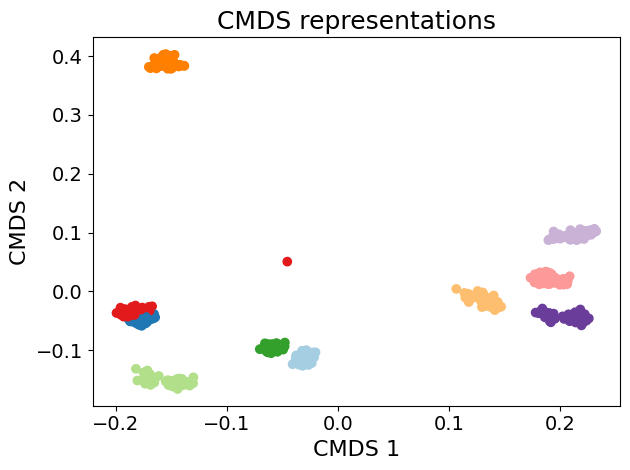

In [7]:
embds = []
n_p_use=20

labels = []

for length in length_list:
    for i, question in enumerate(question_list):
        if length == 0:
            embds += list(embeddings_dict[dict_key][length][question][0])
            
            labels+=[i]
            continue
        
        for mc in range(n_p_use):
            embds += list(embeddings_dict[dict_key][length][question][mc])
            labels+=[i]
            
embds=np.vstack(embds)
cmds_embds = ClassicalMDS(n_components=2).fit_transform(embds)
labels=np.array(labels)

fig, ax = plt.subplots(1,1)

ax.scatter(cmds_embds[:, 0], cmds_embds[:, 1], c=np.array(colors)[labels])
# ax.legend()

ax.set_title('CMDS representations', fontsize=18)
ax.set_ylabel('CMDS 2', fontsize=16)
ax.set_xlabel('CMDS 1', fontsize=16)

ax.tick_params(labelsize=14)

plt.tight_layout()

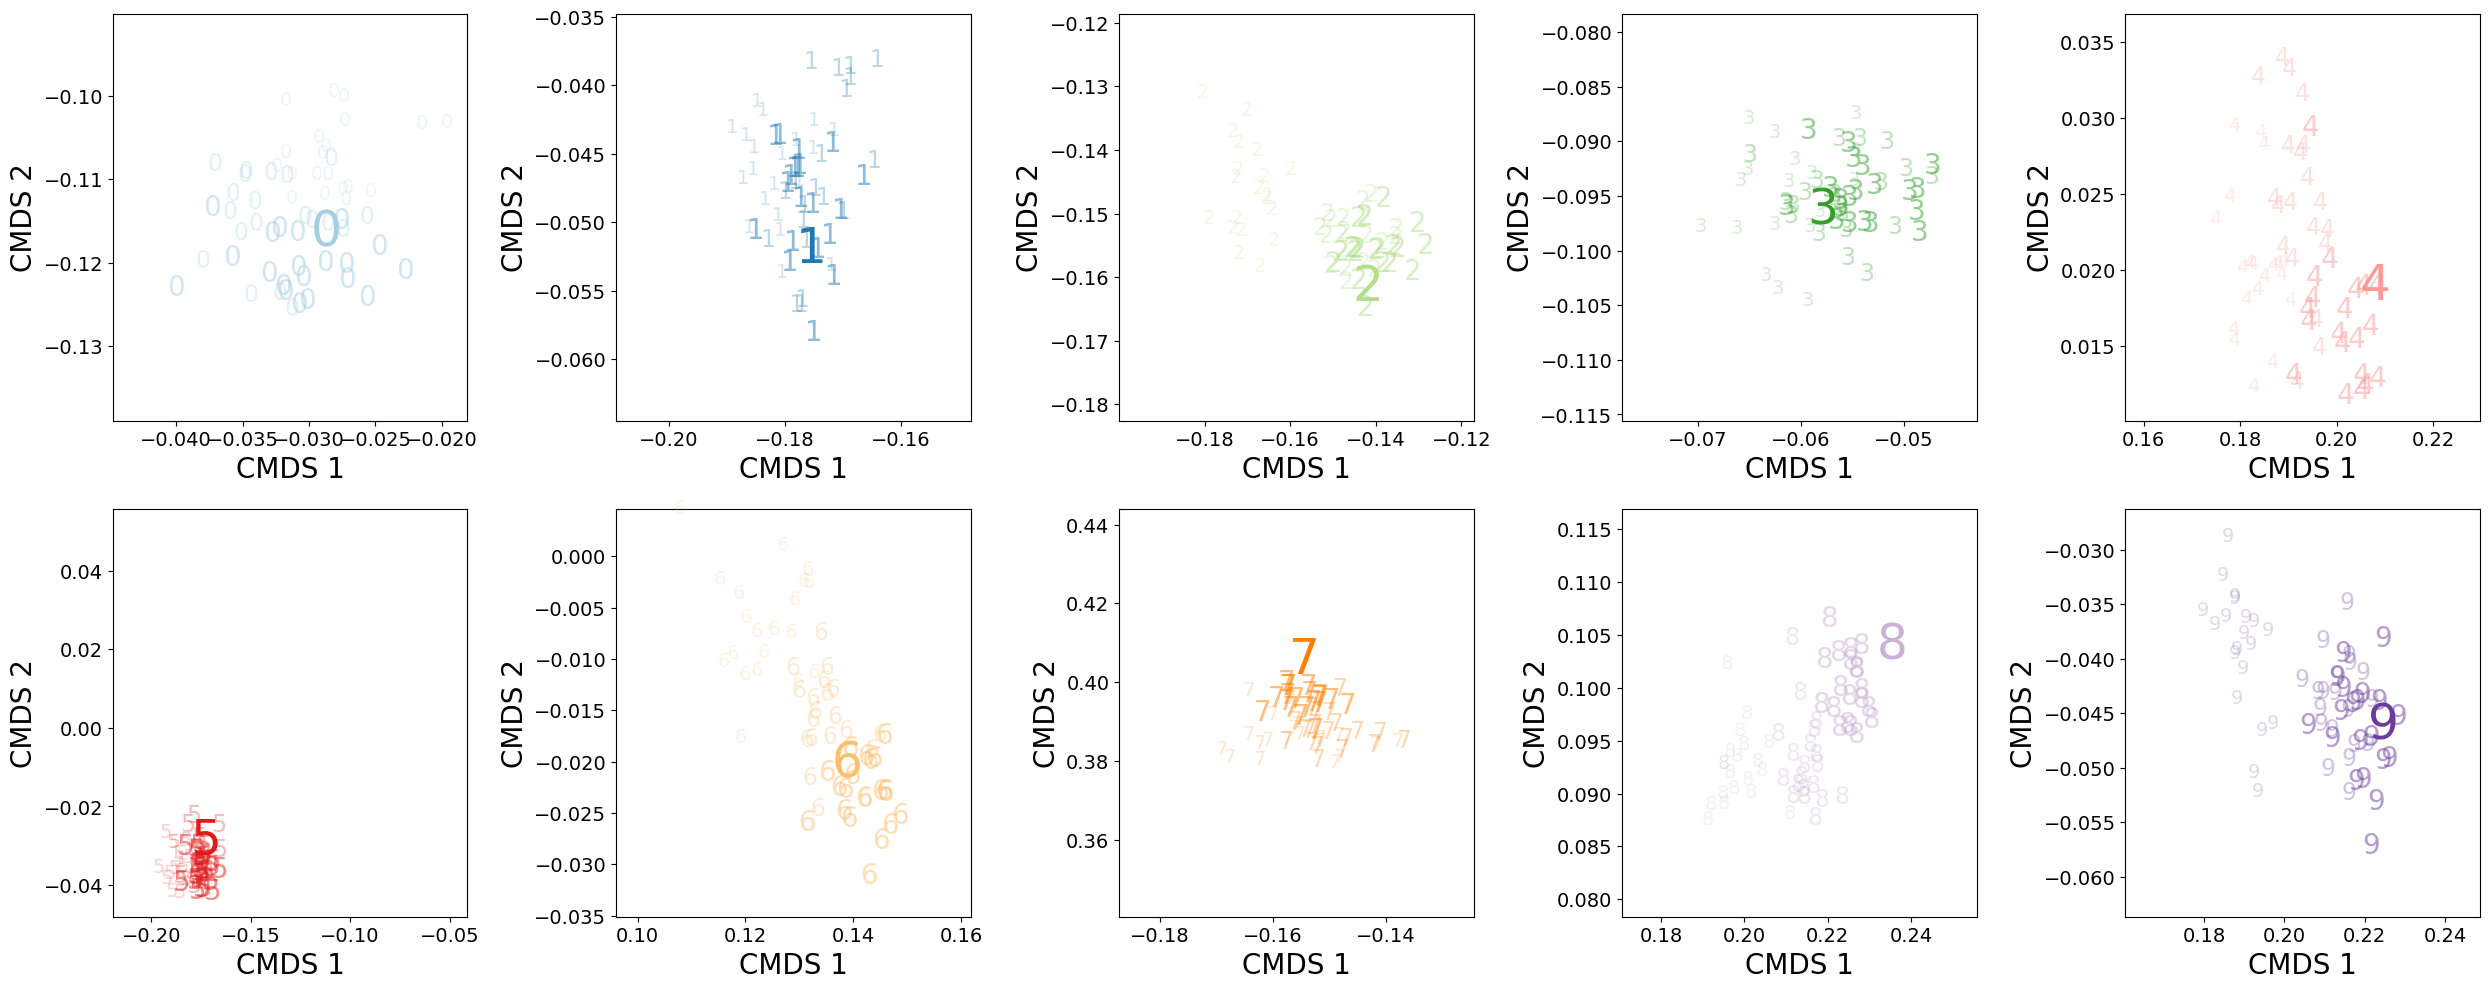

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))

fontsize_list=[35] + [20 - j*3 for j in range(len(length_list[1:]))]
alpha_list=[1, 0.5, 0.3, 0.2, 0.1]

for i, question in enumerate(question_list):
    col = i % 5
    row = int(np.math.floor(i/5))
    
    inds = np.where(labels==i)[0]
    
    for j, length in enumerate(length_list):
        fs = fontsize_list[j]
        a=alpha_list[j]
        if j == 0:
            ind = inds[0]
            ax[row, col].text(cmds_embds[ind, 0], cmds_embds[ind, 1], s=i, alpha=a, fontsize=fs, c=colors[i])
            continue
        
        temp_inds = inds[1 + j*n_p_use: 1 + (j+1)*n_p_use]
        
        for ind in temp_inds:
            ax[row, col].text(cmds_embds[ind, 0], cmds_embds[ind, 1], s=i, alpha=a, fontsize=fs, c=colors[i])
            
    miny = np.min(cmds_embds[inds, 1])
    maxy = np.max(cmds_embds[inds, 1])
    
    minx = np.min(cmds_embds[inds, 0])
    maxx = np.max(cmds_embds[inds, 0])
    
    ax[row, col].set_xlim(minx - 0.1*abs(minx), maxx + 0.1*abs(maxx))
    ax[row, col].set_ylim(miny - 0.1*abs(miny), maxy + 0.1*abs(maxy))
                
    ax[row, col].set_xlabel('CMDS 1', fontsize=20)
    ax[row, col].set_ylabel('CMDS 2', fontsize=20)
    
    ax[row, col].tick_params(labelsize=14)

plt.tight_layout()

In [9]:
embedding_distances_dict = {}

cmds_embds_dict = {}
cmds_embds_dict[0] = {}

for length in tqdm(length_list[1:]):
    embedding_distances_dict[length] = []
    cmds_embds_dict[length] = {}
    for mc in range(n_p_use):
        temp_embeddings = []
        
        for s in embeddings_dict[dict_key][length]:
            temp_embeddings.append(embeddings_dict[dict_key][length][s][mc])
            
        temp_embeddings = np.array(temp_embeddings)
        temp_cmds = ClassicalMDS(n_components=2).fit_transform(temp_embeddings)

        mtx1, mtx2, d = procrustes(base_cmds, temp_cmds)
        cmds_embds_dict[length][mc] = mtx2
        
        if length == length_list[1]:
            if mc == 0:
                cmds_embds_dict[0][0] = mtx1
        
        embedding_distances_dict[length].append(np.linalg.norm(mtx1 - mtx2))

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.77it/s]


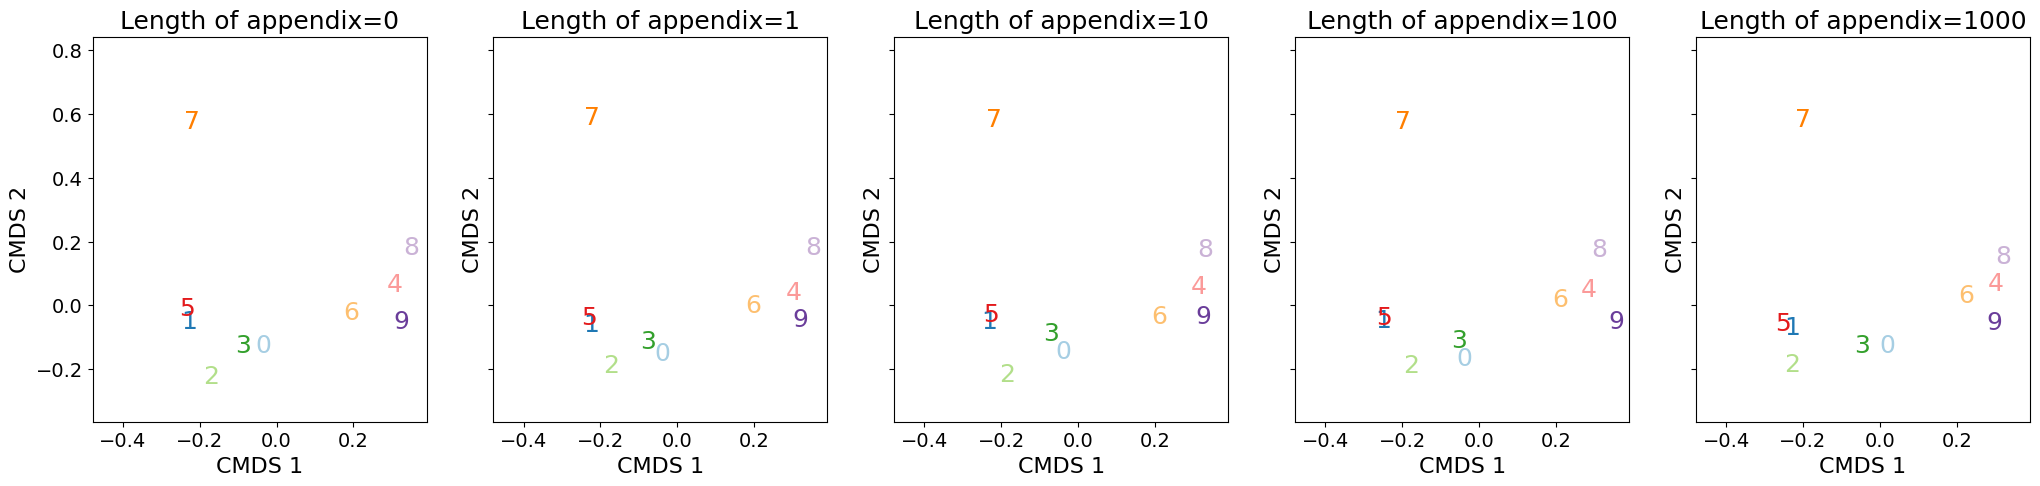

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(25,5), sharex=True, sharey=True)

for ii, p in enumerate(length_list):
    for i in range(10):
        ax[ii].text(cmds_embds_dict[p][0][i, 0], cmds_embds_dict[p][0][i, 1], s=i, fontsize=18, c=colors[i])

    miny = np.min(cmds_embds_dict[p][0][:, 1])
    maxy = np.max(cmds_embds_dict[p][0][:, 1])
    
    minx = np.min(cmds_embds_dict[p][0][:, 0])
    maxx = np.max(cmds_embds_dict[p][0][:, 0])
    
    ax[ii].set_xlim(minx - 0.75*abs(minx), maxx + 0.3*abs(maxx))
    ax[ii].set_ylim(miny - 0.75*abs(miny), maxy + 0.5*abs(maxy))

    ax[ii].set_title(f'Length of appendix={p}', fontsize=18)
    ax[ii].set_ylabel('CMDS 2', fontsize=16)
    ax[ii].set_xlabel('CMDS 1', fontsize=16)

    ax[ii].tick_params(labelsize=14)

In [11]:
from scipy.stats import entropy
entropy_dict = {}
for length in length_list:
    entropy_dict[length] = {}
    for question in question_list:
        entropy_dict[length][question] = {}
        
        for i in range(n_p_use):
            if length==0 and i > 0:
                continue
            
            entropy_dict[length][question][i] = entropy(probs_dict[dict_key][length][question][i])

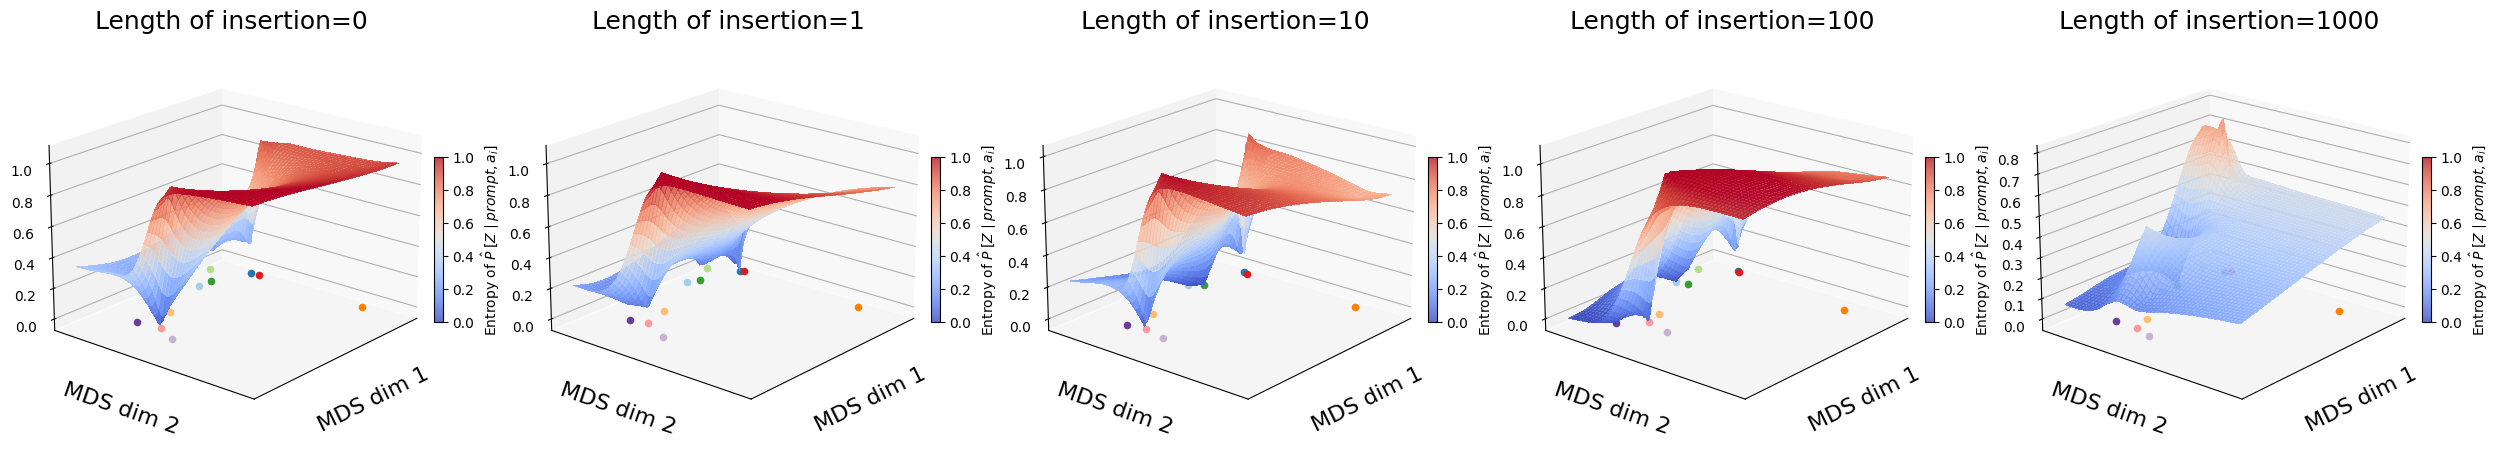

In [12]:
fig = plt.figure(figsize=(25, 5))
fig.add_gridspec(1,5, hspace=0)

for i, length in enumerate(length_list):
    
    entropies = np.array([entropy_dict[length][q][0] for q in question_list])
        
    cmds_embds_p = cmds_embds_dict[length][0]
    
    ax = fig.add_subplot(1, 5, i+1, projection='3d')
    
    xg, yg = np.meshgrid(cmds_embds_p[:, 0], cmds_embds_p[:, 1], indexing='ij')
    interp = RBFInterpolator(cmds_embds_p, entropies, kernel='linear', smoothing=0)
    
    miny = np.min(cmds_embds_p[:, 1])
    maxy = np.max(cmds_embds_p[:, 1])
    
    minx = np.min(cmds_embds_p[:, 0])
    maxx = np.max(cmds_embds_p[:, 0])
    
    xx = np.linspace(minx - 0.2*abs(minx), maxx + 0.2*abs(maxx), 100)
    yy = np.linspace(miny - 0.2*abs(miny), maxy + 0.2*abs(maxy), 100)
    X, Y = np.meshgrid(xx, yy, indexing='ij')
    
    grid = np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1)), axis=1)
    vals = interp(grid)
    
    Surface = ax.plot_surface(X, Y, vals.reshape(100, 100), color='m', cmap=cm.coolwarm, antialiased=False, linewidth=0, vmin=0, vmax=1, alpha=0.8)

    cs=['purple', 'orange']
    for i in range(10):
        color=colors[i]
        ax.scatter(cmds_embds_p[i, 0], cmds_embds_p[i, 1], 0, s=20, color=color)
    
    
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    
    fig.colorbar(Surface, ax=ax, fraction=0.02, pad=0, label=r'Entropy of $\hat P \;[Z \mid prompt, a_i]$')
    # ax.legend(frameon=True, fontsize=12, bbox_to_anchor=(0.3, 0.5))
    ax.set_xlabel("MDS dim 1", fontsize=16)
    ax.set_ylabel("MDS dim 2", fontsize=16)
    ax.view_init(elev=20, azim=40, roll=0)
    
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.set_zlim(0, 1)
    
    ax.set_title(f'Length of insertion={length}', fontsize=18)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Average L2 norm after applying Procrustes transform on Y')

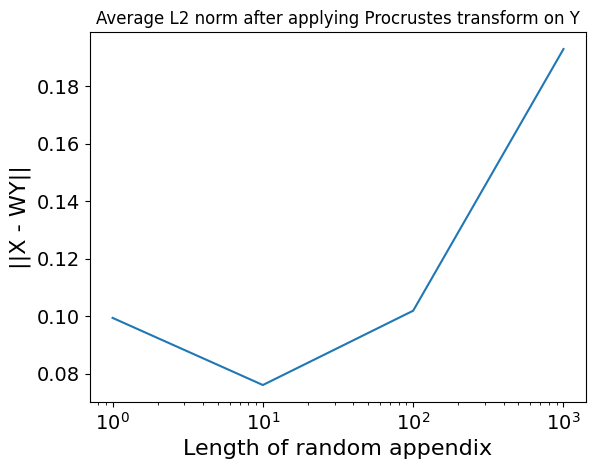

In [13]:
fig, ax = plt.subplots(1,1)
average_distances = [np.mean(v) for v in embedding_distances_dict.values()]

ax.semilogx(length_list[1:], average_distances)
ax.set_ylabel("||X - WY||", fontsize=16)
ax.set_xlabel("Length of random appendix", fontsize=16)
ax.tick_params(labelsize=14)
ax.set_title('Average L2 norm after applying Procrustes transform on Y')

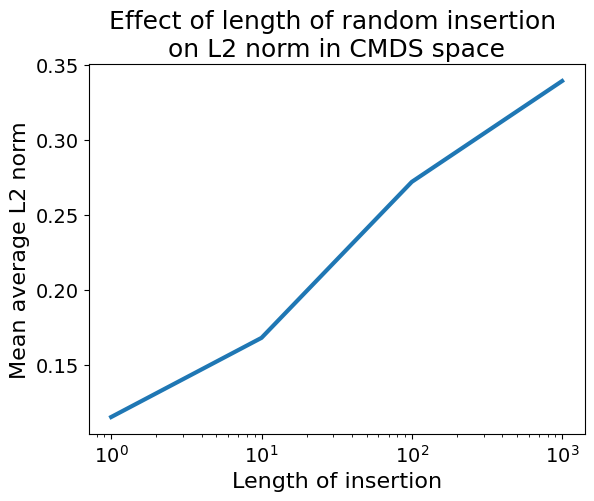

In [14]:
embedding_distances = {}

for i, length in enumerate(length_list[1:]):
    embedding_distances[length] = {}
    offset = i*(10*len(length_list[1:]) + 1)
    base_embd = cmds_embds[offset]
        
    for j, question in enumerate(question_list):
        start = offset + j*10 + 1
        end = offset + (j+1)*10 + 1
                
        temp_embds = cmds_embds[start:end]
        distances = np.linalg.norm(base_embd - temp_embds, axis=1)
        
        embedding_distances[length][question] = distances
    
fig, ax = plt.subplots(1,1)

embd_dist_average_by_length = []
for i, length in enumerate(length_list[1:]):
    temp_avgs = []
    for question in question_list:
        d=embedding_distances[length][question]
        temp_avgs.append(np.mean(d))
    embd_dist_average_by_length.append(np.mean(temp_avgs))
    
ax.semilogx(length_list[1:], embd_dist_average_by_length, lw=3)
ax.set_ylabel('Mean average L2 norm', fontsize=16)
ax.set_xlabel('Length of insertion', fontsize=16)
ax.set_title('Effect of length of random insertion \non L2 norm in CMDS space', fontsize=18)

ax.tick_params(labelsize=14)

# ax.set_yticks([0.01, 0.02, 0.03, 0.04])

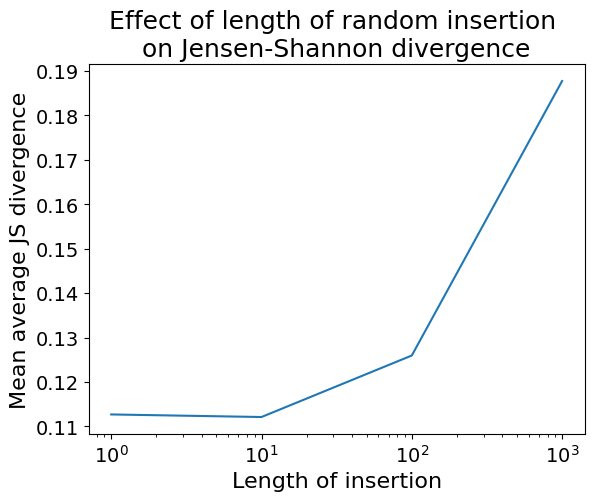

In [15]:
from scipy.spatial.distance import jensenshannon

probs = []
n_p_use=20

js_dict = {l: {} for l in length_list[1:]}

for length in length_list[1:]:
    
    for question in question_list:
        base_prob = probs_dict[dict_key][0][question][0]
        js_dict[length][question] = []
        for mc in range(n_p_use):
            temp = probs_dict[dict_key][length][question][mc]
            
            js_dict[length][question].append(jensenshannon(base_prob, temp))
            
fig, ax = plt.subplots(1,1)

js_average_by_length = []
for i, length in enumerate(length_list[1:]):
    temp_avgs = []
    for question in question_list:
        d=js_dict[length][question]
        temp_avgs.append(np.mean(d))
    js_average_by_length.append(np.mean(temp_avgs))
    
ax.semilogx(length_list[1:], js_average_by_length)
ax.set_ylabel('Mean average JS divergence', fontsize=16)
ax.set_xlabel('Length of insertion', fontsize=16)
ax.set_title('Effect of length of random insertion \non Jensen-Shannon divergence', fontsize=18)

ax.tick_params(labelsize=14)

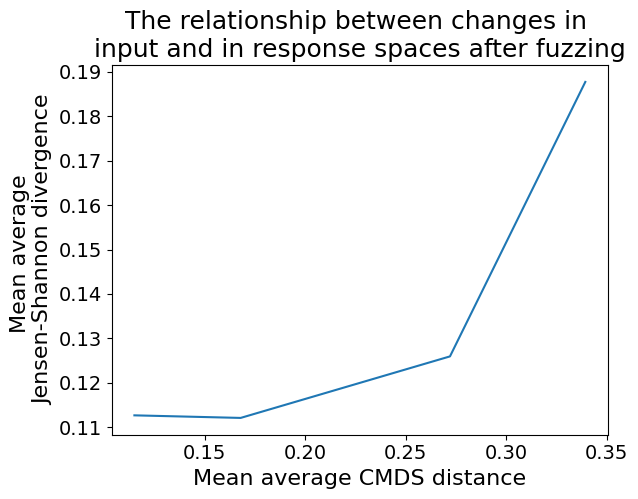

In [16]:
fig, ax = plt.subplots(1,1)

ax.plot(embd_dist_average_by_length, js_average_by_length)
ax.set_xlabel('Mean average CMDS distance', fontsize=16)
ax.set_ylabel('Mean average \nJensen-Shannon divergence', fontsize=16)

ax.set_title('The relationship between changes in \ninput and in response spaces after fuzzing', fontsize=18)
ax.tick_params(labelsize=14)